## acp_research - Tests et recherches ajoutés - POP2

### Imports

In [27]:
import pandas as pd
# google drive folder access
# from google.colab import drive
# drive.mount("/content/drive", force_remount=True)
# import pickle

import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn import decomposition
from sklearn import preprocessing
# classe pour l'ACP
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
# classe pour k-means
from sklearn.cluster import KMeans
# classe pour cah
from scipy.cluster.hierarchy import linkage, fcluster

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import linkage, fcluster
# sns.set(style="white")
sns.set_palette("GnBu_d")

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

### Load datas

In [16]:
# Table pop3_df_base.csv
path_df_base = "./datas/pop2_df_base.csv"
df_base = pd.read_csv(path_df_base, sep=',', error_bad_lines=False, index_col=0)

### Functions

In [39]:
def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(6,6))

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 50 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey", width=0.008)
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='13', ha='right', va='bottom', rotation=label_rotation, color="blue", alpha=0.5)
            
            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # initialisation de la figure   
            colors = sns.cubehelix_palette(8, start=.5, rot=-.75)
            fig = plt.figure(figsize=(6,6))
        
            # affichage des points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], marker='.', alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], c=colors, alpha=alpha, label=value)
                plt.legend()

            # affichage des labels des points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='10', ha='center',va='center') 
                
            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection des individus (sur F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)

def plot_dendrogram(Z):
#     plt.figure(figsize=(4,7))
    plt.figure(figsize=(8,4))
    plt.title('Hierarchical Clustering Dendrogram - Groupe POP2')
    plt.ylabel('distance')
    dendrogram(
        Z,
#         labels = None,
        orientation = "top",
    )
    plt.show()
    
def df_base_disp(columns_names, fig_w, fig_h):

  fig_dims = (fig_w, fig_h)
  nb_plots = len(columns_names)
  fig, axs = plt.subplots(ncols=nb_plots, figsize=fig_dims)
  skewValue = 0
  kurtosis = 0

  for i, name in enumerate(columns_names):
    # print(i, name)
    x_data =  df_base[name]
    # skewvalue
    skewValue = x_data.skew()
    # kurtosis
    kurtosis = x_data.kurtosis()
    disp = "Skew: %0.3f - kurtosis: %0.3f" % (skewValue, kurtosis)
    # print(disp)

    # plot
    # ax = sns.kdeplot(x_data, shade=True, ax=axs[i])
    ax = sns.distplot(x_data, ax=axs[i])
    # add text annotation
    ax.set_title(disp)

In [40]:
# sns.cubehelix_palette(8, start=2, rot=0, dark=0, light=.95, reverse=True)
sns.cubehelix_palette(8, start=.5, rot=-.75)

[[0.8423298817793848, 0.8737404427964184, 0.7524954030731037],
 [0.6825187635707243, 0.810691907283208, 0.6352470180118206],
 [0.5109365778646006, 0.7367198696575319, 0.5730408794126332],
 [0.3720866446574984, 0.6378633419526029, 0.5550368905837924],
 [0.2884627663592704, 0.5163814459748142, 0.5434217716422115],
 [0.24670155725826665, 0.37340824813905654, 0.49725690696587516],
 [0.2217962654723154, 0.23841378594571613, 0.39797674055755683],
 [0.17250549177124488, 0.11951843162770594, 0.24320155229883056]]

### Verification datas

In [18]:
print('df_base.shape :', df_base.shape)
print("Total missing values = ", df_base.isna().sum().sum())
df_base[['tage_PS', 'diplome_interv', 'revenu', 'imc', 'restaurationrapide_freq', 'collation_freq', 
         'pain_cereales_bio', 'fruits_legumes_bio', 'produits_laitiers_bio', 'viandes_poissons_bio', 
         'consommation_bio', 'tv_duree', 'ordi_duree', 'travail_duree', 'sedentarite_duree', 
         'activite_total_duree', 'activite_domloissport_duree']].describe()

df_base.shape : (2288, 21)
Total missing values =  0


,tage_PS,diplome_interv,revenu,imc,restaurationrapide_freq,collation_freq,pain_cereales_bio,fruits_legumes_bio,produits_laitiers_bio,viandes_poissons_bio,consommation_bio,tv_duree,ordi_duree,travail_duree,sedentarite_duree,activite_total_duree,activite_domloissport_duree
count,2288.000000,2288.000000,2288.000000,2288.000000,2288.000000,2288.000000,2288.000000,2288.000000,2288.000000,2288.000000,2288.000000,2288.000000,2288.000000,2288.000000,2288.000000,2288.000000,2288.000000
mean,7.867133,4.582605,8.533217,25.793700,1.569073,2.624239,0.350962,0.392045,0.695367,0.496066,0.428322,3.213525,1.870503,3.506600,6.349799,10.123324,2.398787
std,0.771601,1.907616,3.575501,4.930130,0.809681,0.975023,0.677961,0.707674,0.928269,0.736328,0.494944,1.760040,1.421218,1.711142,3.216838,3.607025,2.146942
min,7.000000,1.000000,1.000000,15.776830,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.142860,0.077308,0.035714,0.142860,0.119044,0.002976
25%,7.000000,3.000000,6.000000,22.320882,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000,2.429770,3.999996,7.644349,1.057664
50%,8.000000,4.000000,9.000000,25.037310,1.184441,2.066871,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,1.585665,2.429770,6.000000,10.118902,1.773805
75%,8.000000,6.000000,12.000000,28.394135,2.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000,2.250825,5.000000,8.464276,12.416915,3.053947
max,9.000000,8.000000,13.000000,52.608677,6.000000,5.000000,3.000000,3.000000,3.000000,3.000000,1.000000,9.000000,9.000000,14.271429,16.997459,17.000002,25.830357


## ACP - df_base

In [19]:
# print(list(df_base))
df_base.head()

,NOIND,agglo_5cl,sex_PS,tage_PS,diplome_interv,revenu,imc,fume,restaurationrapide_freq,collation_freq,pain_cereales_bio,fruits_legumes_bio,produits_laitiers_bio,viandes_poissons_bio,consommation_bio,tv_duree,ordi_duree,travail_duree,sedentarite_duree,activite_total_duree,activite_domloissport_duree
0,110100101,1,1,7,3.0,12,18.282312,0.0,2.000000,5.000000,1,0,1.0,0,0.0,2.142860,3.571430,2.429770,8.142860,8.614090,0.110119
1,110100701,1,2,8,3.0,11,23.624619,0.0,1.000000,1.000000,1,2,2.0,2,1.0,1.928570,0.357140,4.000000,6.666670,10.569450,3.160715
2,110100801,1,1,8,3.0,11,29.949701,1.0,1.000000,2.066871,0,0,0.0,0,0.0,0.928570,0.142860,2.429770,1.714290,3.015881,1.178572
3,110101201,1,1,8,6.0,11,26.141914,0.0,1.000000,3.000000,0,0,0.0,0,0.0,3.023461,4.031272,5.714286,13.664864,17.000000,3.422618
4,110101401,1,2,9,3.0,6,22.420361,0.0,1.184441,2.000000,1,0,3.0,1,1.0,1.500000,1.585665,2.429770,1.500000,3.882939,2.160719


In [25]:
# choix du nombre de composantes à calculer
n_comp = 8

# selection des colonnes à prendre en compte dans l'ACP
data_pca = df_base[['revenu', 'imc', 'restaurationrapide_freq', 'collation_freq', 'fruits_legumes_bio', 
                    'tv_duree', 'travail_duree', 'activite_total_duree']]

# Utile pour définitions clusters CAH
revenu = [df_base.loc[id, "revenu"] for id in df_base.index]
# revenu = [df_base.loc[id, "tage_PS"] for id in df_base.index]


# préparation des données pour l'acp
X = data_pca.values
# names = df_base.index
names = df_base['NOIND']
# features = df_base.columns
features = ['sex_PS', 'tage_PS', 'diplome_interv', 'revenu', 'imc', 'fume', 'restaurationrapide_freq', 
            'collation_freq', 'consommation_bio', 'fruits_legumes_bio', 'tv_duree', 'travail_duree', 
            'activite_total_duree']

# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

# vérification moyenne
print(np.mean(X_scaled,axis=0))
# vérification écart-type
print(np.std(X_scaled,axis=0,ddof=0))

# print(X_scaled)

[-5.27938222e-17 -6.98741764e-17 -2.79496706e-17 -3.08999136e-16
 -5.43465816e-18  1.68474403e-16  1.69250783e-16 -1.91765795e-16]
[1. 1. 1. 1. 1. 1. 1. 1.]


## Choix du nombre de composantes

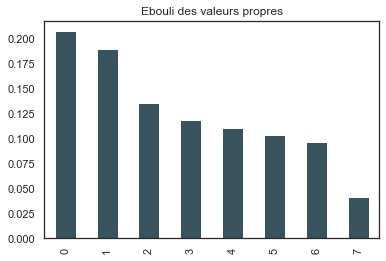

In [21]:
# Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
# principalComponents = pca.fit(X_scaled)
principalComponents = pca.fit_transform(X_scaled)

# Ebouli
ebouli = pd.Series(pca.explained_variance_ratio_)
ebouli.plot(kind='bar', title="Ebouli des valeurs propres")
plt.show()

In [22]:
# Calcul des composantes principales
n_comp_selected = 6
pca = decomposition.PCA(n_components=n_comp_selected)
principalComponents = pca.fit_transform(X_scaled)

### Cercle des corrélations - df_base

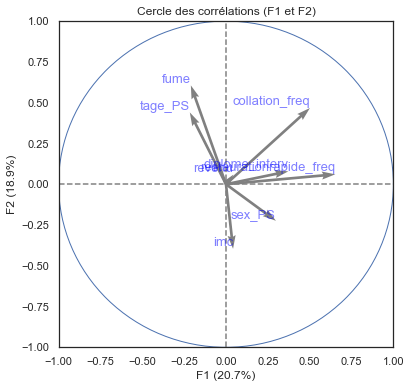

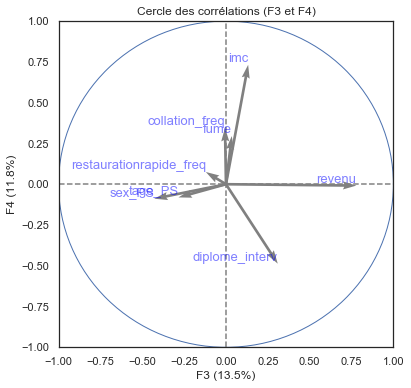

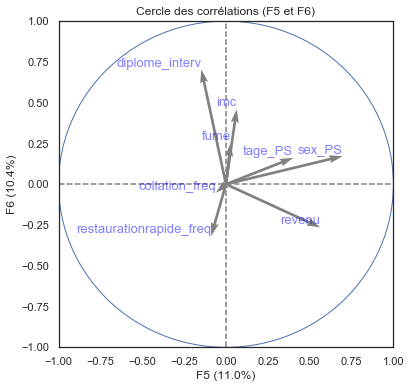

In [23]:
# Cercle des corrélations
pcs = pca.components_
display_circles(pcs, n_comp_selected, pca, [(0,1),(2,3),(4,5)], labels = np.array(features))

### Projection des individus - df_base

ValueError: 'c' argument has 8 elements, which is not acceptable for use with 'x' with size 189, 'y' with size 189.

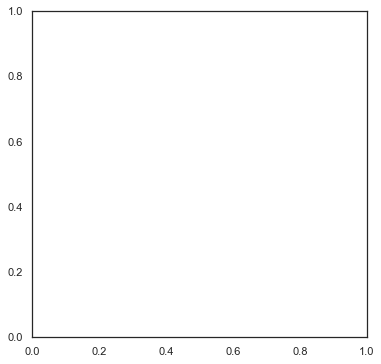

In [41]:
# Projection des individus
X_projected = pca.transform(X_scaled)
display_factorial_planes(X_projected, n_comp_selected, pca, [(0,1),(2,3),(4,5)], illustrative_var = revenu, labels = None)

plt.show()

## CAH - df_base

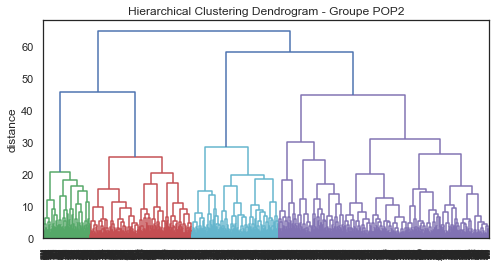

In [18]:
# Clustering hiérarchique
Z = linkage(X_scaled, 'ward')

# Affichage du dendrogramme
plot_dendrogram(Z)

## k-means - df_base

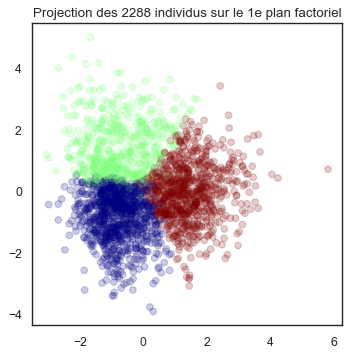

In [19]:
# Nombre de clusters souhaités
n_clust = 3

# import de l'échantillon
data_km = data_pca

# préparation des données pour le clustering
X = data_km.values

# Réduire n'est ici pas nécessaire car les variables sont exprimées dans la même unité
X_scaled = preprocessing.StandardScaler().fit_transform(X)

# Clustering par K-means
km = KMeans(n_clusters=n_clust)
km.fit(X_scaled)

# Récupération des clusters attribués à chaque individu
clusters = km.labels_

# Affichage du clustering par projection des individus sur le premier plan factoriel
pca = decomposition.PCA(n_components=6).fit(X_scaled)
X_projected = pca.transform(X_scaled)
plt.figure(figsize=(5, 5), dpi=80)
plt.scatter(X_projected[:, 0], X_projected[:, 1], c=clusters.astype(np.float), cmap = 'jet', alpha=.2)
plt.title("Projection des {} individus sur le 1e plan factoriel".format(X_projected.shape[0]))

plt.show(block=False)

## Tentative d'interprétation des clusters - df_base

In [20]:
# Coupage du dendrogramme en 12 clusters
clusters = fcluster(Z, 5, criterion='maxclust')
#clusters = fcluster(Z, 159, criterion='distance') # ligne équivalente à la précédente

revenu = [df_base.loc[id, "revenu"] for id in df_base.index]

# Comparaison des clusters trouvés avec les classification des cours en différents thèmes
individus = pd.DataFrame({"revenu": revenu, "cluster": clusters, "title": names})
# individus['revenu'] = [data_cah.loc[revenu_id, "revenu"] for revenu_id in data.index]
# individus

# table_conting = individus.pivot_table(index="revenu", columns="cluster", aggfunc=len, fill_value=0)
# table_conting
# table_conting.sum()

## ACP - principalDf (à partir de composantes principales)

In [21]:
principalDf = pd.DataFrame(data = principalComponents, columns = ['F1', 'F2', 'F3', 'F4', 'F5', 'F6'])
principalDf.head()

,F1,F2,F3,F4,F5,F6
0,0.408529,-1.085906,2.063448,-1.019905,1.383292,-0.536255
1,0.465006,-1.769529,-1.445875,1.843514,-0.437296,0.755934
2,-1.413643,-1.399317,-1.229106,-1.298395,0.705011,-0.368250
3,1.743954,0.966858,-0.476719,0.588978,0.561407,-1.257342
4,-1.366849,-1.435116,-0.168972,-0.982014,-0.960143,-0.608456


In [22]:
principalDf.describe()

,F1,F2,F3,F4,F5,F6
count,2.288000e+03,2.288000e+03,2.288000e+03,2.288000e+03,2.288000e+03,2.288000e+03
mean,-1.242208e-17,3.105519e-18,2.794967e-17,-2.173863e-17,-4.192451e-17,-1.397484e-17
std,1.287212e+00,1.230606e+00,1.038407e+00,9.738381e-01,9.392051e-01,9.102214e-01
min,-3.036068e+00,-3.904920e+00,-2.726825e+00,-3.374240e+00,-2.957369e+00,-2.950387e+00
25%,-1.011735e+00,-7.783550e-01,-7.748913e-01,-6.265030e-01,-6.152984e-01,-5.917751e-01
50%,-2.232997e-01,-7.633082e-02,-1.175094e-01,-1.237016e-01,4.996940e-02,-9.119682e-02
75%,1.007590e+00,7.046187e-01,6.726182e-01,5.502943e-01,6.252126e-01,5.168004e-01
max,5.815803e+00,4.998137e+00,3.823874e+00,4.447389e+00,2.985413e+00,4.802590e+00


## k-means principalDf

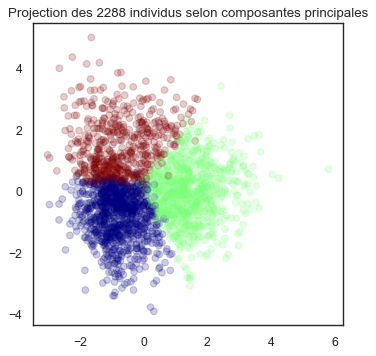

In [23]:
# Nombre de clusters souhaités
n_clust = 3

# import de l'échantillon
principalDf_km = principalDf

# préparation des données pour le clustering
X = principalDf_km.values

# Réduire n'est ici pas nécessaire car les variables sont exprimées dans la même unité
# X_scaled = preprocessing.StandardScaler().fit_transform(X)

# Clustering par K-means
km = KMeans(n_clusters=n_clust)
km.fit(X)

# Récupération des clusters attribués à chaque individu
clusters = km.labels_

# Affichage du clustering par projection des individus sur le premier plan factoriel
pca = decomposition.PCA(n_components=3).fit(X)
X_projected = pca.transform(X)
plt.figure(figsize=(5, 5), dpi=80)
plt.scatter(X_projected[:, 0], X_projected[:, 1], c=clusters.astype(np.float), cmap = 'jet', alpha=.2)
plt.title("Projection des {} individus selon composantes principales".format(X_projected.shape[0]))

plt.show(block=False)

## CAH principalDf

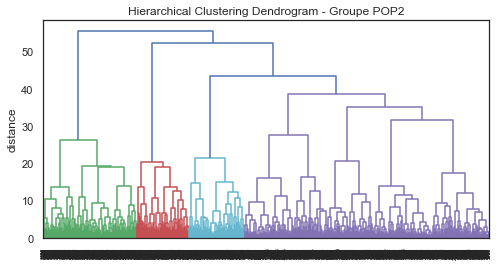

In [24]:
data_cah = principalDf

# préparation des données pour le clustering
X = data_cah.values
names = data_cah.index

# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

# Clustering hiérarchique
Z = linkage(X_scaled, 'ward')

# Affichage du dendrogramme
plot_dendrogram(Z)

## CAH from centroids

In [25]:
#  centroids
km.cluster_centers_

array([[-0.80016129, -0.8325188 , -0.03079095, -0.11733586,  0.04946519,
         0.06245903],
       [ 1.41531828, -0.03984012, -0.11227572, -0.0442834 , -0.0881339 ,
        -0.16447824],
       [-0.75049039,  1.45343867,  0.21744551,  0.26197402,  0.04734052,
         0.13835863]])

values passed to leaf_label_func
leaves :  [1, 0, 2]


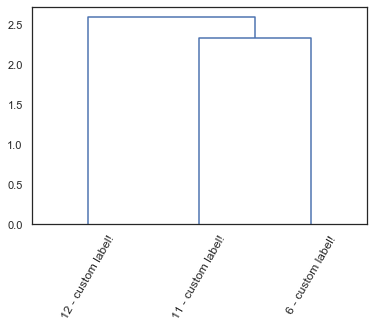

In [26]:
# préparation des données pour le clustering
X = km.cluster_centers_
# names = data_km.revenu
# ['sex_PS', 'tage_PS', 'diplome_interv', 'revenu', 'imc', 'fume', 'restaurationrapide_freq', 'collation_freq', 'consommation_bio', 'fruits_legumes_bio', 'tv_duree', 'travail_duree']

# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

# Clustering hiérarchique
Z = linkage(X, 'ward')

labels = data_km.revenu.unique()
p = len(labels)

R = dendrogram(
                Z,
                truncate_mode='lastp',  # show only the last p merged clusters
#                 p=p,  # show only the last p merged clusters
                no_plot=True,
                )

print("values passed to leaf_label_func\nleaves : ", R["leaves"])

# create a label dictionary
temp = {R["leaves"][ii]: labels[ii] for ii in range(len(R["leaves"]))}

def llf(xx):
    return "{} - custom label!".format(temp[xx])

# Affichage du dendrogramme
dendrogram(
            Z,
            truncate_mode='lastp',  # show only the last p merged clusters
#             p=p,  # show only the last p merged clusters
            leaf_label_func=llf,
            leaf_rotation=60.,
            leaf_font_size=12.,
            show_contracted=True,  # to get a distribution impression in truncated branches
            )
plt.show()

## Comparaison principalComponents / imc

In [27]:
principalComponents

array([[ 0.40852854, -1.08590596,  2.06344779, -1.01990453,  1.38329205,
        -0.53625508],
       [ 0.46500605, -1.76952913, -1.44587471,  1.84351359, -0.43729555,
         0.75593366],
       [-1.41364317, -1.39931654, -1.22910631, -1.29839471,  0.70501053,
        -0.36825038],
       ...,
       [ 0.97729036,  0.01914788,  1.80289221, -1.60666216, -0.99832328,
         1.75972726],
       [-1.78442916,  2.05387291, -0.17653515,  1.19560575, -2.64910526,
         0.16916266],
       [ 1.91644948, -0.00343784, -0.98524532, -0.69994498, -0.10901996,
        -0.43061587]])

In [28]:
principalComponents_df = pd.DataFrame(principalComponents, columns=['F1', 'F2', 'F3', 'F4', 'F5', 'F6'])
principalComponents_df

,F1,F2,F3,F4,F5,F6
0,0.408529,-1.085906,2.063448,-1.019905,1.383292,-0.536255
1,0.465006,-1.769529,-1.445875,1.843514,-0.437296,0.755934
2,-1.413643,-1.399317,-1.229106,-1.298395,0.705011,-0.368250
3,1.743954,0.966858,-0.476719,0.588978,0.561407,-1.257342
4,-1.366849,-1.435116,-0.168972,-0.982014,-0.960143,-0.608456
...,...,...,...,...,...,...
2283,0.420042,0.469649,0.560797,-0.319930,-2.318435,-0.541277
2284,-0.545613,1.775153,0.270369,1.061221,0.279236,-0.048288
2285,0.977290,0.019148,1.802892,-1.606662,-0.998323,1.759727
2286,-1.784429,2.053873,-0.176535,1.195606,-2.649105,0.169163


In [29]:
# principalComponents_df = principalComponents_df[['F1','F2','F3','F4','F5','F6']].copy()
principalComponents_df.rename(columns={'F1': 'MALBOUFFE', 'F2': 'FUMEUR', 'F3': 'RESSOURCE', 'F4': 'SANTE', 'F5': 'SOCIO-DEMO', 'F6': 'EDUCATION'}, inplace=True)
principalComponents_df

,MALBOUFFE,FUMEUR,RESSOURCE,SANTE,SOCIO-DEMO,EDUCATION
0,0.408529,-1.085906,2.063448,-1.019905,1.383292,-0.536255
1,0.465006,-1.769529,-1.445875,1.843514,-0.437296,0.755934
2,-1.413643,-1.399317,-1.229106,-1.298395,0.705011,-0.368250
3,1.743954,0.966858,-0.476719,0.588978,0.561407,-1.257342
4,-1.366849,-1.435116,-0.168972,-0.982014,-0.960143,-0.608456
...,...,...,...,...,...,...
2283,0.420042,0.469649,0.560797,-0.319930,-2.318435,-0.541277
2284,-0.545613,1.775153,0.270369,1.061221,0.279236,-0.048288
2285,0.977290,0.019148,1.802892,-1.606662,-0.998323,1.759727
2286,-1.784429,2.053873,-0.176535,1.195606,-2.649105,0.169163


In [30]:
imc_arr = df_base[['imc']].values
principalComponents_df['imc'] = imc_arr[:,]
# print("Total missing values = ", principalComponents_df.isna().sum())
principalComponents_df
# print(list(principalComponents_df))

,MALBOUFFE,FUMEUR,RESSOURCE,SANTE,SOCIO-DEMO,EDUCATION,imc
0,0.408529,-1.085906,2.063448,-1.019905,1.383292,-0.536255,18.282312
1,0.465006,-1.769529,-1.445875,1.843514,-0.437296,0.755934,23.624619
2,-1.413643,-1.399317,-1.229106,-1.298395,0.705011,-0.368250,29.949701
3,1.743954,0.966858,-0.476719,0.588978,0.561407,-1.257342,26.141914
4,-1.366849,-1.435116,-0.168972,-0.982014,-0.960143,-0.608456,22.420361
...,...,...,...,...,...,...,...
2283,0.420042,0.469649,0.560797,-0.319930,-2.318435,-0.541277,22.405876
2284,-0.545613,1.775153,0.270369,1.061221,0.279236,-0.048288,21.170218
2285,0.977290,0.019148,1.802892,-1.606662,-0.998323,1.759727,17.245743
2286,-1.784429,2.053873,-0.176535,1.195606,-2.649105,0.169163,20.239500


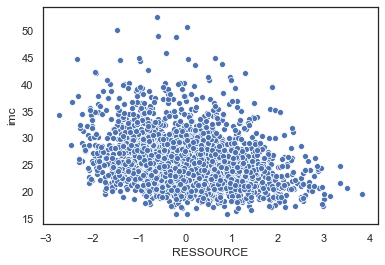

In [31]:
sns.set(style="white")
ax = sns.scatterplot(x="RESSOURCE", y="imc", data=principalComponents_df)

## ACP composantes + imc

In [34]:
# choix du nombre de composantes à calculer
n_comp = 7

# selection des colonnes à prendre en compte dans l'ACP
data_pca = principalComponents_df

# préparation des données pour l'ACP
X = data_pca.values
names = principalComponents_df.index
features = ['MALBOUFFE', 'FUMEUR', 'RESSOURCE', 'SANTE', 'SOCIO-DEMO', 'EDUCATION', 'imc']

# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

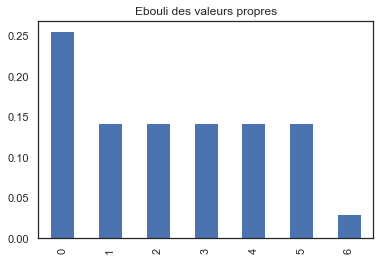

In [35]:
# Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
# principalComponents = pca.fit(X_scaled)
principalComponents = pca.fit_transform(X_scaled)

# Ebouli
ebouli = pd.Series(pca.explained_variance_ratio_)
ebouli.plot(kind='bar', title="Ebouli des valeurs propres")
plt.show()

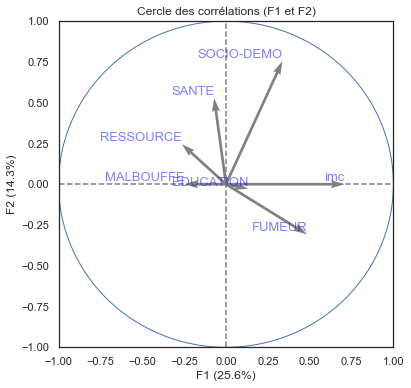

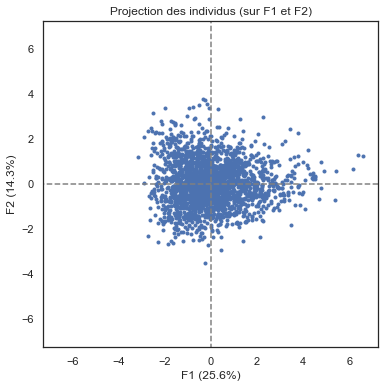

In [281]:
n_comp_select = 2

# Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp_select)
pca.fit(X_scaled)

# Cercle des corrélations
pcs = pca.components_
display_circles(pcs, n_comp, pca, [(0,1)], labels = np.array(features))

# Projection des individus
X_projected = pca.transform(X_scaled)
display_factorial_planes(X_projected, n_comp_select, pca, [(0,1)], labels = None)

plt.show()